In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

**Methods and definitions.**

In [2]:
def my_pie(data, group, title, ax=None, figsize=None):
    data.groupby([group]).size().plot.pie(
        title=title, 
        ylabel='', 
        autopct=lambda p:'{:.1f}% ({:.0f})'.format(p, (p/100)*data.groupby([group]).size().sum()),
        figsize=figsize,
        ax=ax
    )

def my_bar(data, group, title, ax=None, figsize=None):
    ax_t = data.groupby([group]).size().plot.bar(
        title=title, 
        ylabel='count', 
        figsize=figsize,
        ax=ax
    )
    ax_t.bar_label(ax_t.containers[0])

def my_hist_with_qq(data, column, title, xlabel, figsize=(15, 6)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    data[column].plot.hist(title=title, ax=ax1)
    ax1.set_xlabel(xlabel)
    
    with mpl.rc_context():
        mpl.rc("figure", figsize=(3,3))
        sm.qqplot(data[column], line ='45', fit=True, ax=ax2)

def my_count(data, column, title, ax=None, order=None):
    fig, ax_t = plt.subplots()
    ax_t = sns.countplot(
        y = column, 
        data = data, 
        order = order, 
        ax=ax,
        palette='deep'
    )
    ax_t.bar_label(ax_t.containers[0])
    ax_t.set_title(title)

def my_box(data, columns, title, xlabel='count', ax=None, figsize=None):
    fig, ax_t = plt.subplots(figsize=figsize)
    ax_t = sns.boxplot(
        data=data[[x for x in data.columns if x in columns]],
        orient='h',
        ax=ax,
        palette='deep'
    ).set(xlabel=xlabel, title=title)

def my_box_xy(data, x, y, title, xlabel='count', ax=None, order=None):
    if(not ax):
        fig, ax_t = plt.subplots()
    sns.boxplot(
        data=data,
        orient='h',
        ax=ax,
        x=x,
        y=y,
        palette='deep',
        order=order
    ).set(xlabel=xlabel, title=title)
    
def my_dist(data, x, hue, title):
    sns.displot(
        data=data, 
        x=x, 
        hue=hue, 
        kind="kde",
    ).set(title=title)
    
def my_test(test, data, column, group, title):
    print(title)
    cols = [data[data[group] == x][column] for x in data[group].unique()]
    stat = test(*cols)
    print("{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))

    if(stat.pvalue < 0.05 and test == stats.kruskal):
        p_vals = []

        for comb in list(combinations(cols, 2)):
            stat = stats.mannwhitneyu(*comb)
            p_vals.append(stat.pvalue)

        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(data[group].unique(), 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')
        

def my_chi(data, group1, group2, merge_index=False, merge_cols=False):
    counts = data.groupby([group1, group2]).size().unstack().fillna(0)
    
    if(merge_index):
        for index in merge_index:
            for index2 in merge_index[index]:
                counts.loc[index] = counts.loc[index] + counts.loc[index2]
                counts = counts.drop(axis=0, index=[index2])
        
    if(merge_cols):
        for col in merge_cols:
            for col2 in merge_cols[col]:
                counts.loc[:, col] = counts.loc[:, col] + counts.loc[:, col2]
                counts = counts.drop(axis=1, columns=[col2])
                
    print(counts, end='\n\n')
    
    stat, p, d, exp = stats.chi2_contingency(counts)
    print("{low}pvalue: {p}\n".format(p=p, low='----> ' if p < 0.05 else ''))
    print('expected frequencies:')
    print(exp, end='\n\n')
    
    if(p < 0.05):
        p_vals = []

        for comb in list(combinations(counts.columns, 2)):
            new_df = counts[[comb[0], comb[1]]]
            chi2, p, dof, ex = stats.chi2_contingency(new_df)
            p_vals.append(p)
        with np.errstate(divide='ignore'):
            reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

        print('Post-hoc testing:')
        combs = list(combinations(counts.columns, 2))
        for index, comp in enumerate(combs):
            print('{:20}{:20}{:20}'.format(str(combs[index]), corrected_p_vals[index], reject_list[index]))
        print('\n\n')

def my_bar_grouped(data, column, group, title, hue_order=None, ax=None):
    plt.figure(tight_layout=True)
    ax_t = sns.barplot(
        data=data.groupby([column, group]).size().reset_index(), 
        y=0, 
        x=column, 
        hue=group,
        palette='deep',
        linewidth=2,
        hue_order = hue_order,
        ax=ax
    ).set(title=title, xlabel=column, ylabel='count')

def my_mean_plot(data, columns, group, title, label_x=None, label_y=None, order=None):
    if(not order):
        data.groupby([group]).mean().reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    else:
        data.groupby([group]).mean().loc[order].reset_index().plot(x = group, y= columns, title=title, figsize=(5, 3))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
def my_heatmap(data, columns):
    corr = data[columns].corr(method='spearman')
    sns.heatmap(corr, annot=True)
    
def multiple_tests(test, columns, labels):
    p_vals = []

    for comb in list(combinations(columns, 2)):
        stat = test(*comb)
        p_vals.append(stat.pvalue)

    if(test == stats.kruskal or test == stats.mannwhitneyu):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    if(test == stats.chi2_contingency):
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_gbs')[:2]

    print('Post-hoc testing:')
    print(list(combinations(labels, 2)))
    print(corrected_p_vals)
    print(reject_list, end='\n\n\n')
    
def my_test2(test, followup_test, columns, title, labels):
    print(title)
    stat = test(*columns)
    for i in range(len(columns)):
        print(labels[i] + ' mean: ' + str(columns[i].mean()))
        print(labels[i] + ' std: ' + str(columns[i].std()))
    print("\n{low}pvalue: {p}\n".format(p=stat.pvalue, low='----> ' if stat.pvalue < 0.05 else ' '))
    
    if(stat.pvalue < 0.05 and len(columns) > 2):
        multiple_tests(stats.mannwhitneyu, columns, labels)
    

attrak = {
    'PQ1': 'complicated - simple', 
    'PQ2': 'impractical - practical', 
    'PQ3': 'unpredictable - predictable', 
    'PQ4': 'confusing - clearly constructed', 
    'HQ1': 'tacky - stylish', 
    'HQ2': 'cheap - premium', 
    'HQ3': 'unimaginative - creative', 
    'HQ4': 'dull - captivating', 
    'ATT1': 'ugly - attractive', 
    'ATT2': 'bad - good',
    'PQ': 'All pragmatic qualities',
    'HQ': 'All hedonic qualities',
    'ATT': 'All attractiveness qualities'
}

open_text = {
    'company': 'Company\'s name',
    'purpose': 'Company\'s purpose',
    'purpose_token_count': 'Number of full meaning words in purpose',
    'purpose_word_count': 'Number of words in purpose question',
    'detail': 'Website\'s detail',
    'desc_eval_comp': 'Description complexity',
    'desc_eval_elem': 'Number of identified elements in description',
    'desc_eval_char': 'Number of identified characterists in description',
    'desc_eval_sum': 'Sum of identified characteristics and elements in description',
    'desc_token_count': 'Number of full meaning words in description',
    'desc_word_count': 'Number of words in description'
}

# Time - complexity relationship

**Load and merge data.**

In [3]:
results = pd.read_csv("../data/results.csv", index_col=0)
respondents = pd.read_csv("../data/respondents.csv", index_col=0)
respondents = respondents[respondents.status=='completed']
data = results.merge(respondents[
    ['respondent', 'interval', 'time_taken', 
     'vmt_levels', 'vmt_levels_group',
     'vmt_click_speed', 'vmt_click_speed_group', 
     'vmt_press_len', 'vmt_press_len_group',
     'pst_levels', 'pst_levels_group',
     'pst_mistakes', 'pst_mistakes_group',
     'pst_press_speed', 
     'age', 'gender', 'education', 'web_browsing', 'web_skill']
], on=['respondent', 'interval'], how='outer')

**Calculate groups**

In [4]:
data['task_interval'] = ''
for index, row in data.iterrows():
    data.loc[index, 'task_interval'] = str(int(np.floor((row.task - 1) / 2))) + '_' + row.interval

In [5]:
fixed_data = data[(data.interval != '2s') | (data.interval == '2s') & (data.respondent != 50)]

**Mean.**

In [6]:
data[['task', 'interval'] + list(attrak.keys())].groupby(['task', 'interval']).mean()

PQ1    PQ2    PQ3    PQ4    HQ1    HQ2    HQ3    HQ4   ATT1  \
task interval                                                                  
1    10s       5.825  5.675  5.200  5.800  5.025  4.550  4.100  4.075  5.175   
     2s        5.600  5.450  5.100  5.600  5.075  4.775  4.225  4.500  5.150   
     5s        6.000  5.700  5.375  5.825  5.150  4.700  4.275  4.375  5.350   
2    10s       5.025  5.150  4.900  5.000  4.375  4.225  4.000  3.925  4.700   
     2s        5.275  5.325  5.000  5.025  4.600  4.550  4.125  4.425  4.875   
     5s        5.275  5.325  4.800  5.175  4.875  4.575  4.350  4.475  5.175   
3    10s       5.100  5.400  4.925  5.425  5.125  5.025  4.775  4.875  5.275   
     2s        4.675  4.875  4.675  4.925  4.850  4.700  4.475  4.575  5.000   
     5s        4.775  5.225  4.775  4.950  4.600  4.700  4.425  4.700  5.125   
4    10s       4.625  5.500  5.025  4.925  4.200  3.775  3.850  4.075  4.375   
     2s        4.875  5.650  5.600  5.375  4.250  3.800  3.525  4.000  4.375   
     5s        4.725  5.400  5.425  5.125  4.300  3.900  4.025  4.125  4.250   
5    10s       4.325  4.575  4.475  4.275  3.600  3.325  3.575  4.025  3.950   
     2s        3.875  4.175  4.125  3.775  2.925  2.800  3.250  3.575  3.250   
     5s        3.975  4.425  4.275  4.000  3.600  3.300  3.825  3.925  3.775   
6    10s       2.975  3.900  4.075  3.400  3.800  3.500  2.775  2.825  3.075   
     2s        3.125  4.100  4.225  3.800  3.600  3.775  3.100  3.225  3.125   
     5s        2.950  3.825  4.375  3.600  3.725  3.650  3.125  3.125  3.000   

                ATT2       PQ       HQ     ATT  
task interval                                   
1    10s       5.175  5.62500  4.43750  5.1750  
     2s        5.425  5.43750  4.64375  5.2875  
     5s        5.225  5.72500  4.62500  5.2875  
2    10s       4.575  5.01875  4.13125  4.6375  
     2s        4.875  5.15625  4.42500  4.8750  
     5s        4.850  5.14375  4.56875  5.0125  
3    10s       5.175  5.21250  4.95000  5.2250  
     2s        4.950  4.78750  4.65000  4.9750  
     5s        5.100  4.93125  4.60625  5.1125  
4    10s       4.750  5.01875  3.97500  4.5625  
     2s        5.000  5.37500  3.89375  4.6875  
     5s        4.900  5.16875  4.08750  4.5750  
5    10s       4.050  4.41250  3.63125  4.0000  
     2s        3.700  3.98750  3.13750  3.4750  
     5s        3.925  4.16875  3.66250  3.8500  
6    10s       3.425  3.58750  3.22500  3.2500  
     2s        3.750  3.81250  3.42500  3.4375  
     5s        3.650  3.68750  3.40625  3.3250

In [7]:
data[['task', 'interval'] + list(open_text.keys())].groupby(['task', 'interval']).mean()

company  purpose  purpose_token_count  purpose_word_count  \
task interval                                                              
1    10s        1.0000   0.9750                2.325               3.375   
     2s         0.9000   1.0000                2.200               3.050   
     5s         0.9750   0.9250                2.550               3.950   
2    10s        0.9375   1.0000                3.400               4.375   
     2s         0.7875   0.6500                2.575               3.775   
     5s         0.9625   0.8250                2.575               3.825   
3    10s        0.9000   0.9500                3.225               4.175   
     2s         0.9000   0.8000                2.950               4.700   
     5s         0.8375   0.9125                2.775               3.900   
4    10s        0.9750   1.0000                2.750               3.825   
     2s         0.9625   1.0000                2.575               4.000   
     5s         1.0000   0.9750                2.550               4.225   
5    10s        0.9000   0.9500                2.325               4.325   
     2s         0.9375   0.4875                1.800               3.750   
     5s         0.9625   0.7875                2.800               5.525   
6    10s        0.9125   0.7250                2.850               5.275   
     2s         0.9000   0.6125                2.550               5.025   
     5s         0.9625   0.6375                2.700               4.375   

               detail  desc_eval_comp  desc_eval_elem  desc_eval_char  \
task interval                                                           
1    10s       0.3000           1.250           1.800           0.575   
     2s        0.1500           0.875           1.325           0.475   
     5s        0.1500           1.100           1.375           0.700   
2    10s       0.5750           1.150           1.975           0.325   
     2s        0.6000           0.725           1.350           0.425   
     5s        0.5750           0.825           1.400           0.550   
3    10s       0.3000           1.125           2.375           0.150   
     2s        0.0875           0.925           1.875           0.150   
     5s        0.1500           0.900           1.725           0.350   
4    10s       0.3750           1.175           1.950           0.225   
     2s        0.1500           0.825           1.475           0.325   
     5s        0.3375           0.975           1.550           0.500   
5    10s       0.3625           0.925           1.675           0.300   
     2s        0.1875           0.500           1.000           0.475   
     5s        0.3750           0.800           0.975           0.725   
6    10s       0.0625           0.950           1.450           0.425   
     2s        0.1125           0.750           1.125           0.650   
     5s        0.1375           0.875           1.300           0.750   

               desc_eval_sum  desc_token_count  desc_word_count  
task interval                                                    
1    10s               2.375            11.675           24.375  
     2s                1.800            10.050           20.275  
     5s                2.075            10.400           22.400  
2    10s               2.300            11.525           22.650  
     2s                1.775             8.625           20.075  
     5s                1.950            10.825           21.000  
3    10s               2.525            11.325           23.400  
     2s                2.025             9.125           20.150  
     5s                2.075            10.175           23.725  
4    10s               2.175            10.325           20.650  
     2s                1.800             9.025           19.725  
     5s                2.050             9.975           20.275  
5    10s               1.975            10.225           22.200  
     2s                1.475             6.

**Median.**

In [8]:
data[['task', 'interval'] + list(attrak.keys())].groupby(['task', 'interval']).median()

PQ1  PQ2  PQ3  PQ4  HQ1  HQ2  HQ3  HQ4  ATT1  ATT2     PQ  \
task interval                                                              
1    10s       6.0  6.0  5.0  6.0  5.0  4.0  4.0  4.0   5.0   5.0  5.750   
     2s        6.0  5.0  5.0  5.5  5.0  5.0  4.0  4.0   5.0   5.0  5.375   
     5s        6.0  6.0  5.0  6.0  5.0  5.0  4.0  4.0   5.0   5.0  5.875   
2    10s       5.0  5.0  5.0  5.0  4.0  4.0  4.0  4.0   5.0   5.0  5.000   
     2s        5.0  5.0  5.0  5.0  4.0  5.0  4.0  4.0   5.0   5.0  5.125   
     5s        5.0  5.0  5.0  5.0  5.0  5.0  4.0  5.0   5.0   5.0  5.250   
3    10s       5.0  5.5  5.0  6.0  5.0  5.0  5.0  5.0   5.0   5.0  5.250   
     2s        5.0  5.0  5.0  5.0  5.0  5.0  4.0  5.0   5.0   5.0  5.000   
     5s        5.0  5.0  5.0  5.0  5.0  5.0  4.0  5.0   5.0   5.0  5.000   
4    10s       4.5  6.0  5.0  5.0  4.0  4.0  4.0  4.0   4.0   5.0  5.000   
     2s        5.0  6.0  6.0  5.0  4.0  4.0  4.0  4.0   4.0   5.0  5.250   
     5s        5.0  6.0  5.0  5.0  4.0  4.0  4.0  4.0   4.0   5.0  5.250   
5    10s       5.0  5.0  4.5  4.0  4.0  3.0  3.0  4.0   4.0   4.0  4.625   
     2s        4.0  4.0  4.0  4.0  3.0  3.0  3.0  4.0   3.0   4.0  4.000   
     5s        4.0  4.5  4.0  3.5  3.5  3.0  4.0  4.0   4.0   4.0  3.875   
6    10s       3.0  4.0  4.0  3.0  4.0  4.0  3.0  3.0   3.0   3.0  3.750   
     2s        3.0  4.0  4.0  4.0  4.0  4.0  3.0  3.0   3.0   4.0  4.000   
     5s        2.5  4.0  4.0  3.0  4.0  4.0  3.0  3.0   3.0   4.0  3.375   

                  HQ   ATT  
task interval               
1    10s       4.250  5.00  
     2s        4.625  5.00  
     5s        4.625  5.50  
2    10s       4.125  4.75  
     2s        4.250  4.75  
     5s        4.625  5.00  
3    10s       5.000  5.25  
     2s        4.750  5.00  
     5s        4.750  5.00  
4    10s       4.000  4.50  
     2s        3.750  4.50  
     5s        4.000  4.50  
5    10s       3.750  4.00  
     2s        3.125  3.50  
     5s        3.750  3.75  
6    10s       3.250  3.00  
     2s        3.500  3.50  
     5s        3.375  3.00

In [9]:
data[['task', 'interval'] + list(open_text.keys())].groupby(['task', 'interval']).median()

company  purpose  purpose_token_count  purpose_word_count  \
task interval                                                              
1    10s           1.0     1.00                  2.0                 2.0   
     2s            1.0     1.00                  2.0                 2.0   
     5s            1.0     1.00                  2.0                 2.0   
2    10s           1.0     1.00                  3.5                 4.0   
     2s            1.0     1.00                  2.0                 3.0   
     5s            1.0     1.00                  2.0                 3.0   
3    10s           1.0     1.00                  3.0                 4.0   
     2s            1.0     1.00                  2.0                 3.0   
     5s            1.0     1.00                  2.5                 3.0   
4    10s           1.0     1.00                  2.0                 3.0   
     2s            1.0     1.00                  2.0                 3.0   
     5s            1.0     1.00                  2.0                 3.0   
5    10s           1.0     1.00                  2.0                 4.0   
     2s            1.0     0.25                  1.0                 3.0   
     5s            1.0     1.00                  2.0                 2.0   
6    10s           1.0     1.00                  2.0                 4.0   
     2s            1.0     1.00                  2.0                 3.5   
     5s            1.0     0.50                  2.0                 2.0   

               detail  desc_eval_comp  desc_eval_elem  desc_eval_char  \
task interval                                                           
1    10s          0.0             1.0             2.0             0.0   
     2s           0.0             1.0             1.0             0.0   
     5s           0.0             1.0             1.0             1.0   
2    10s          1.0             1.0             2.0             0.0   
     2s           1.0             1.0             1.0             0.0   
     5s           1.0             1.0             1.0             0.0   
3    10s          0.0             1.0             2.0             0.0   
     2s           0.0             1.0             2.0             0.0   
     5s           0.0             1.0             2.0             0.0   
4    10s          0.0             1.0             2.0             0.0   
     2s           0.0             1.0             1.0             0.0   
     5s           0.0             1.0             1.5             0.0   
5    10s          0.0             1.0             2.0             0.0   
     2s           0.0             0.0             1.0             0.0   
     5s           0.0             1.0             1.0             1.0   
6    10s          0.0             1.0             1.0             0.0   
     2s           0.0             1.0             1.0             0.0   
     5s           0.0             1.0             1.0             1.0   

               desc_eval_sum  desc_token_count  desc_word_count  
task interval                                                    
1    10s                 2.0               9.5             19.0  
     2s                  1.0               8.0             14.5  
     5s                  2.0               9.0             17.0  
2    10s                 2.5              11.5             23.0  
     2s                  2.0               7.0             16.5  
     5s                  2.0               8.0             12.5  
3    10s                 2.0              10.5             20.5  
     2s                  2.0               7.0             16.5  
     5s                  2.0               8.0             14.0  
4    10s                 2.0               8.5             18.0  
     2s                  2.0               7.5             15.0  
     5s                  2.0               8.0             14.5  
5    10s                 2.0              10.0             19.0  
     2s                  1.0               

**Std.**

In [10]:
data[['task', 'interval'] + list(attrak.keys())].groupby(['task', 'interval']).std()

PQ1       PQ2       PQ3       PQ4       HQ1       HQ2  \
task interval                                                               
1    10s       1.034966  1.047280  1.090754  1.114013  1.310461  1.501282   
     2s        1.172331  0.932325  1.057331  1.057331  1.022503  1.208676   
     5s        1.037749  0.939176  0.952392  1.034966  1.098951  0.939176   
2    10s       1.187272  1.075365  1.256777  1.484967  1.147740  1.229707   
     2s        0.905468  0.971055  1.219500  1.270726  0.981887  1.175607   
     5s        1.300641  1.227620  1.324329  1.393897  1.180775  1.375379   
3    10s       0.900142  0.955416  1.047280  0.930605  1.090460  1.025008   
     2s        1.206553  1.343312  0.944281  1.474353  1.051251  0.939176   
     5s        1.367901  1.208676  1.270726  1.449138  1.373747  1.343551   
4    10s       1.274755  1.086042  1.349026  1.268706  0.882886  0.800240   
     2s        1.453334  1.051251  1.150251  1.125178  0.980581  1.304823   
     5s        1.467380  1.335895  1.059451  1.180775  1.042679  1.194002   
5    10s       1.542351  1.483024  1.219237  1.568725  1.215287  1.163273   
     2s        1.324087  1.278771  1.399405  1.476092  1.327954  1.264911   
     5s        1.671595  1.500214  1.300641  1.853617  1.464100  1.264911   
6    10s       1.527315  1.354953  1.384669  1.706699  1.114013  1.219500   
     2s        1.453334  1.410583  1.440931  1.435806  1.081310  1.025008   
     5s        1.753385  1.722960  1.496791  1.780233  0.986771  1.166850   

                    HQ3       HQ4      ATT1      ATT2        PQ        HQ  \
task interval                                                               
1    10s       1.373747  1.384669  1.238020  1.195880  0.860456  1.274441   
     2s        1.270726  1.339728  1.231010  1.009887  0.856255  1.001421   
     5s        1.240089  1.294713  1.075365  1.073874  0.788133  0.982214   
2    10s       1.062170  0.997111  1.090754  1.217132  1.079214  0.947310   
     2s        1.264658  1.195880  1.090460  1.158857  0.899942  1.001921   
     5s        1.331088  1.339489  1.278771  1.311683  1.084399  1.202278   
3    10s       1.097491  1.042372  1.131994  0.902631  0.745822  0.907942   
     2s        1.109111  1.059451  0.987096  1.218448  1.049344  0.846940   
     5s        1.483024  1.343551  1.380960  1.127739  1.054580  1.264515   
4    10s       1.026570  1.163273  0.867874  0.869718  0.977942  0.782009   
     2s        1.219237  1.240347  1.233870  0.960769  0.945638  1.051384   
     5s        1.165476  1.223436  1.354006  1.296939  1.058221  1.010442   
5    10s       1.238020  1.165476  1.395046  1.131144  1.280462  1.066668   
     2s        1.276011  1.375379  1.497862  1.453554  1.135034  1.164306   
     5s        1.517209  1.525636  1.671595  1.558887  1.375597  1.319904   
6    10s       1.329883  1.393897  1.384669  1.174243  1.193667  1.052774   
     2s        1.236206  1.187272  1.180775  1.276011  1.192592  0.966092   
     5s        1.202295  1.066687  1.240347  1.311683  1.445317  0.890994   

                    ATT  
task interval            
1    10s       1.152200  
     2s        1.061491  
     5s        0.946569  
2    10s       1.056042  
     2s        1.048503  
     5s        1.211523  
3    10s       0.926463  
     2s        0.999679  
     5s        1.168428  
4    10s       0.752666  
     2s        1.010759  
     5s        1.211854  
5    10s       1.137924  
     2s        1.381888  
     5s        1.565657  
6    10s       1.165751  
     2s        1.150181  
     5s        1.146623

In [11]:
data[['task', 'interval'] + list(open_text.keys())].groupby(['task', 'interval']).std()

company   purpose  purpose_token_count  purpose_word_count  \
task interval                                                                
1    10s       0.000000  0.158114             1.118321            2.637865   
     2s        0.303822  0.000000             1.181047            2.218223   
     5s        0.158114  0.266747             2.024846            4.025241   
2    10s       0.231702  0.000000             1.706699            2.657235   
     2s        0.390389  0.483046             2.135025            3.990293   
     5s        0.174954  0.367772             1.517209            3.358018   
3    10s       0.281935  0.220721             1.640630            2.836461   
     2s        0.281935  0.388950             2.194983            4.647580   
     5s        0.346919  0.274738             1.671595            3.600570   
4    10s       0.158114  0.000000             1.103607            2.406055   
     2s        0.174954  0.000000             1.692934            3.623287   
     5s        0.000000  0.158114             1.767948            4.736587   
5    10s       0.281935  0.189466             1.268706            3.384637   
     2s        0.231702  0.499840             1.620383            3.814614   
     5s        0.133373  0.373609             3.337433            9.943398   
6    10s       0.250320  0.319254             1.702939            3.896004   
     2s        0.303822  0.445598             2.229752            6.423065   
     5s        0.174954  0.375320             2.162619            4.515997   

                 detail  desc_eval_comp  desc_eval_elem  desc_eval_char  \
task interval                                                             
1    10s       0.464095        1.031553        1.244475        0.712075   
     2s        0.361620        0.965760        0.858965        0.784056   
     5s        0.361620        0.871191        1.102154        0.790975   
2    10s       0.500641        0.833590        1.208676        0.525625   
     2s        0.483046        0.784056        0.948683        0.549475   
     5s        0.487668        0.902631        1.081310        0.782829   
3    10s       0.464095        0.852974        1.462129        0.426675   
     2s        0.274738        0.729858        0.991955        0.361620   
     5s        0.361620        0.900142        1.085747        0.579567   
4    10s       0.490290        0.902631        1.299901        0.479717   
     2s        0.361620        0.812956        1.061868        0.572332   
     5s        0.458362        0.999679        1.280024        0.751068   
5    10s       0.480218        0.858965        1.327954        0.516398   
     2s        0.370161        0.640513        1.176697        0.554122   
     5s        0.477037        0.790975        0.973692        0.678894   
6    10s       0.231702        0.875595        1.280024        0.675107   
     2s        0.309828        0.808608        1.066687        0.802240   
     5s        0.339447        0.882523        1.066987        0.776250   

               desc_eval_sum  desc_token_count  desc_word_count  
task interval                                                    
1    10s            1.352822          6.719232        16.594234  
     2s             1.399634          7.088995        17.089489  
     5s             1.206553          7.149682        19.320243  
2    10s            1.223698          5.296286        11.414229  
     2s             1.187272          5.400321        15.583337  
     5s             1.280024          7.775331        18.408471  
3    10s            1.467380          6.719232        14.235744  
     2s             1.120611          4.962358        13.344643  
     5s             1.308503          8.161471        22.405342  
4    10s            1.337573          6.684799        15.456390  
     2s             1.136797          6.070050        15.832436  
     5s             1.413307          7.105388        17.326410  
5    10s            1.440931  

**Plots**

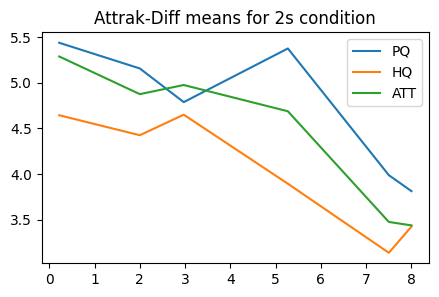

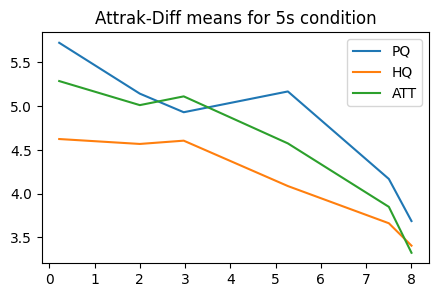

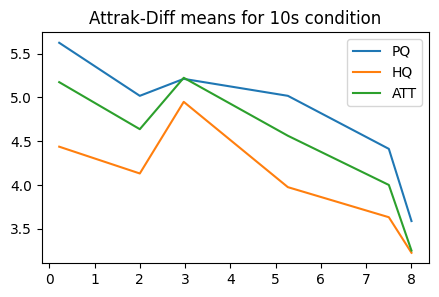

In [12]:
my_mean_plot(data[data.interval == '2s'], ['PQ', 'HQ', 'ATT'], 'complexity', 'Attrak-Diff means for 2s condition')
my_mean_plot(data[data.interval == '5s'], ['PQ', 'HQ', 'ATT'], 'complexity', 'Attrak-Diff means for 5s condition')
my_mean_plot(data[data.interval == '10s'], ['PQ', 'HQ', 'ATT'], 'complexity', 'Attrak-Diff means for 10s condition')

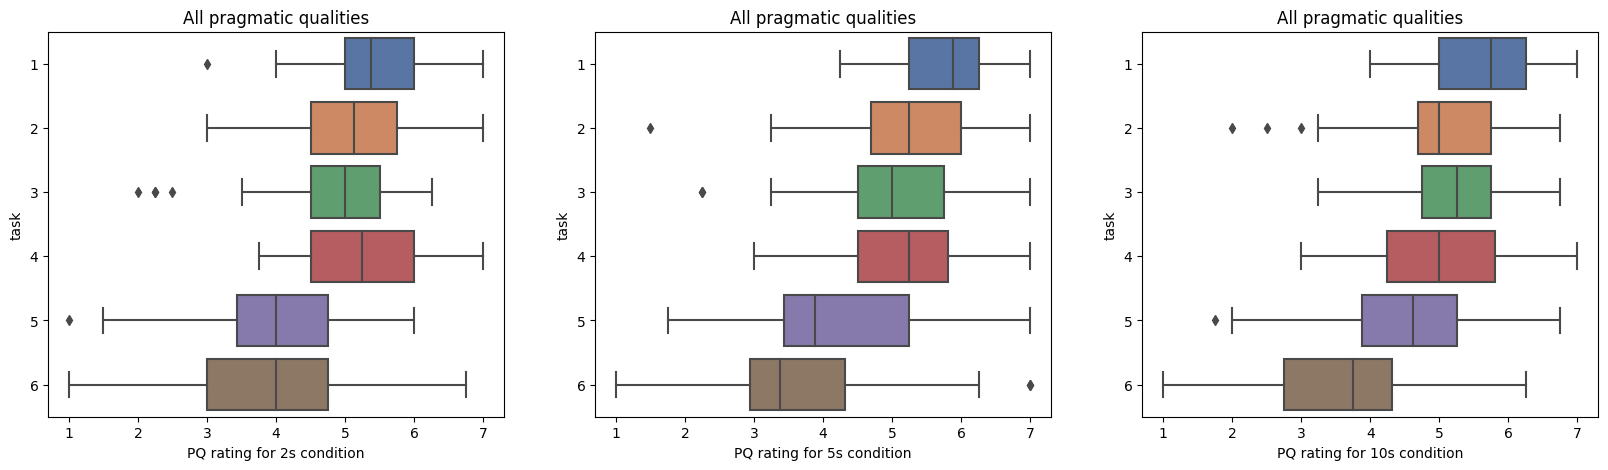

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'PQ', 'task', attrak['PQ'], 'PQ rating for 2s condition', ax1)
my_box_xy(data[data.interval == '5s'], 'PQ', 'task', attrak['PQ'], 'PQ rating for 5s condition', ax2)
my_box_xy(data[data.interval == '10s'], 'PQ', 'task', attrak['PQ'], 'PQ rating for 10s condition', ax3)

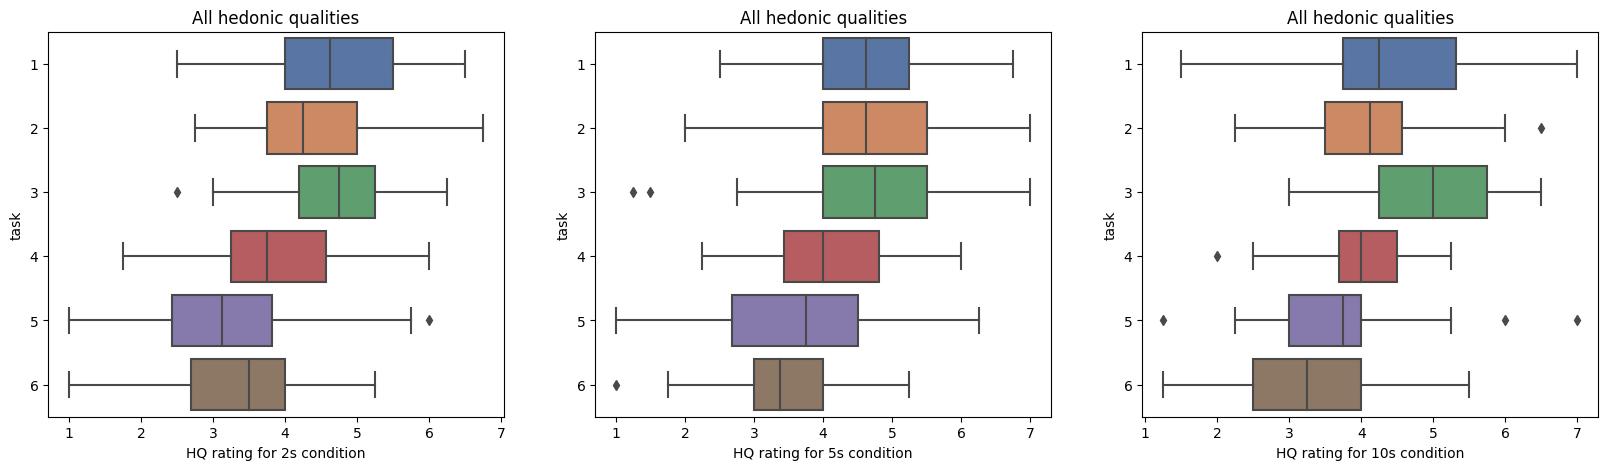

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'HQ', 'task', attrak['HQ'], 'HQ rating for 2s condition', ax1)
my_box_xy(data[data.interval == '5s'], 'HQ', 'task', attrak['HQ'], 'HQ rating for 5s condition', ax2)
my_box_xy(data[data.interval == '10s'], 'HQ', 'task', attrak['HQ'], 'HQ rating for 10s condition', ax3)

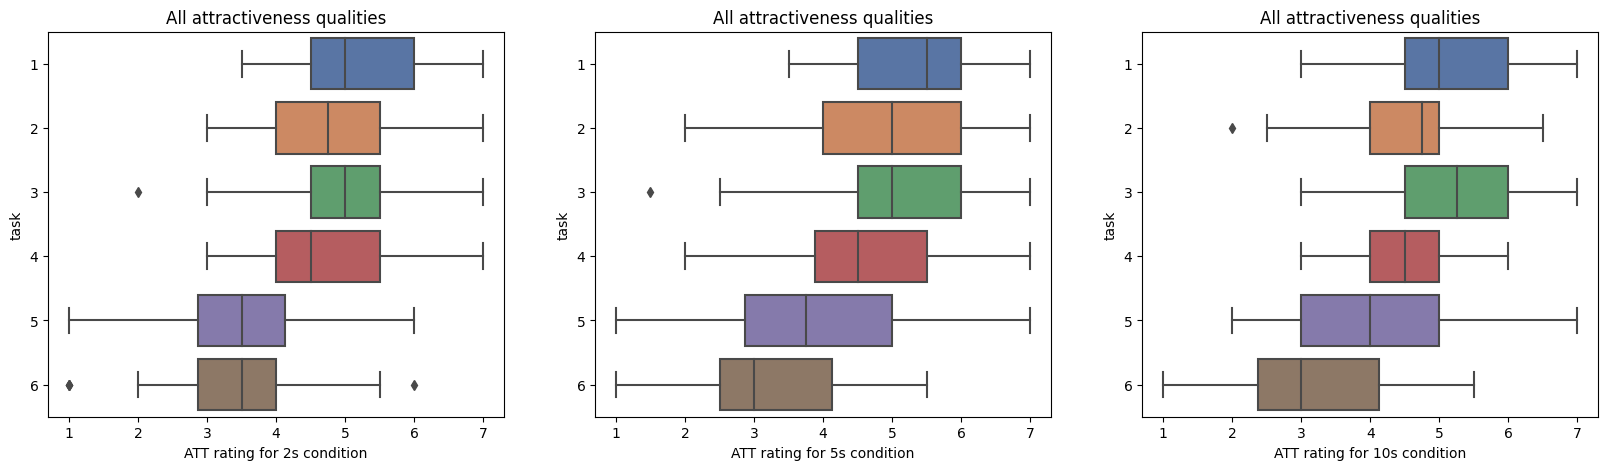

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'ATT', 'task', attrak['ATT'], 'ATT rating for 2s condition', ax1)
my_box_xy(data[data.interval == '5s'], 'ATT', 'task', attrak['ATT'], 'ATT rating for 5s condition', ax2)
my_box_xy(data[data.interval == '10s'], 'ATT', 'task', attrak['ATT'], 'ATT rating for 10s condition', ax3)

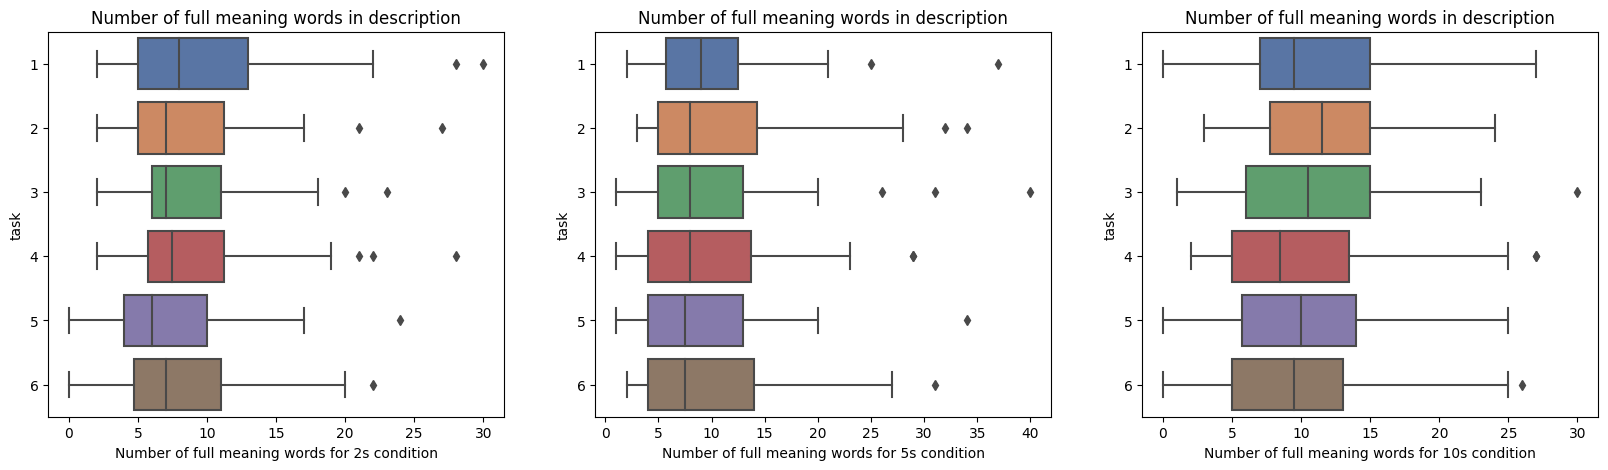

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
my_box_xy(data[data.interval == '2s'], 'desc_token_count', 'task', open_text['desc_token_count'], 'Number of full meaning words for 2s condition', ax1)
my_box_xy(data[data.interval == '5s'], 'desc_token_count', 'task', open_text['desc_token_count'], 'Number of full meaning words for 5s condition', ax2)
my_box_xy(data[data.interval == '10s'], 'desc_token_count', 'task', open_text['desc_token_count'], 'Number of full meaning words for 10s condition', ax3)

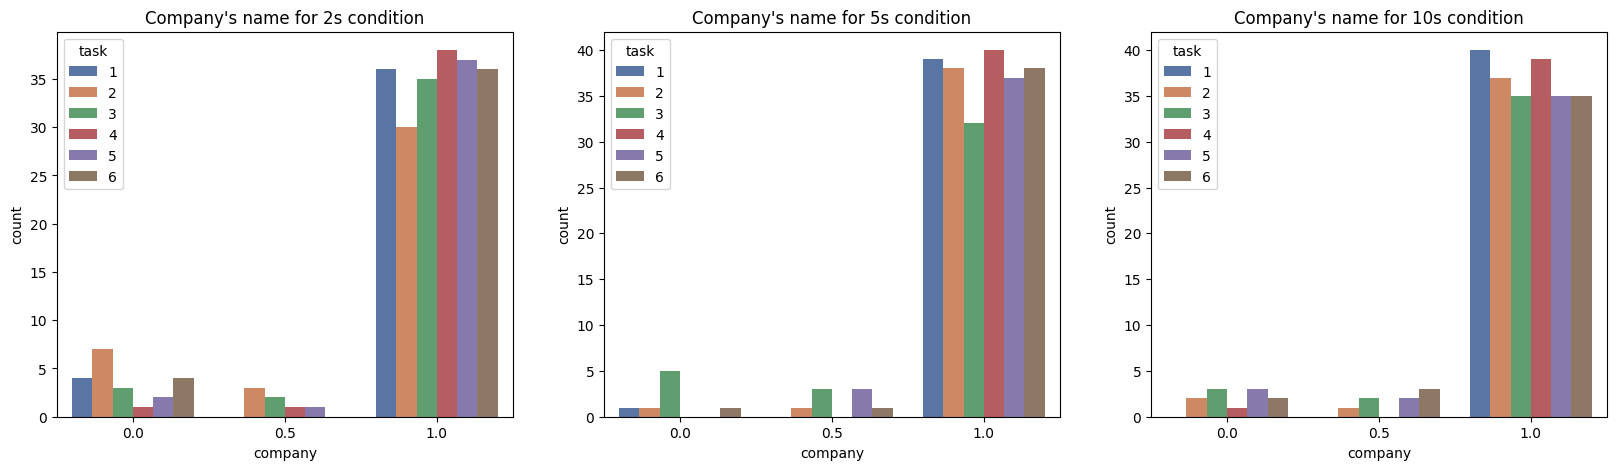

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

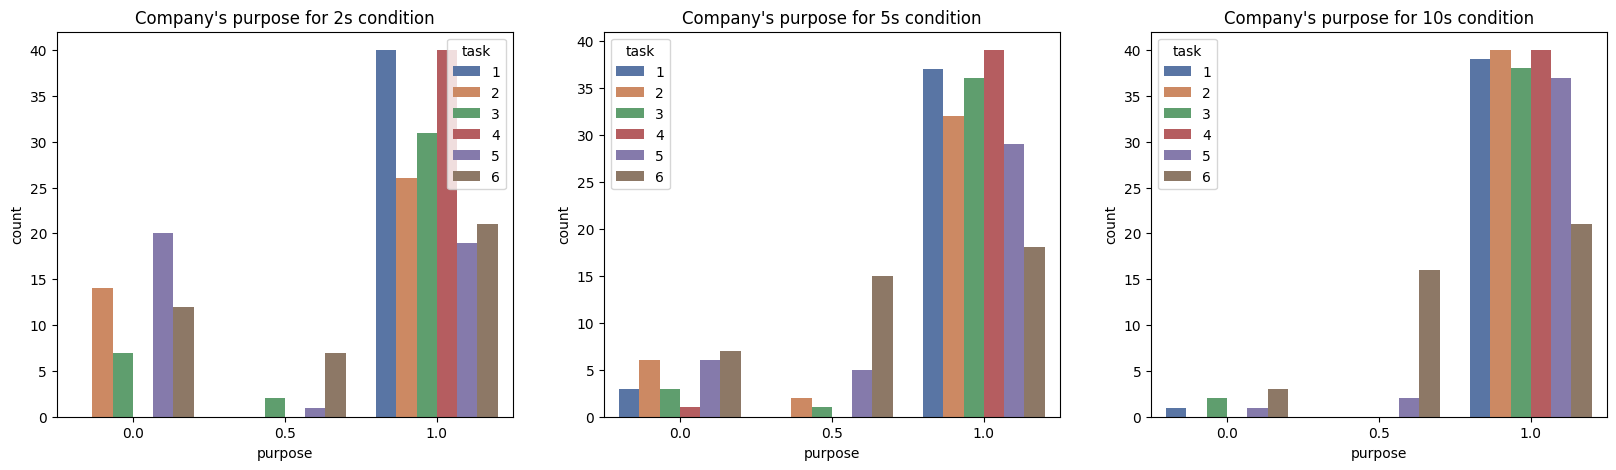

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

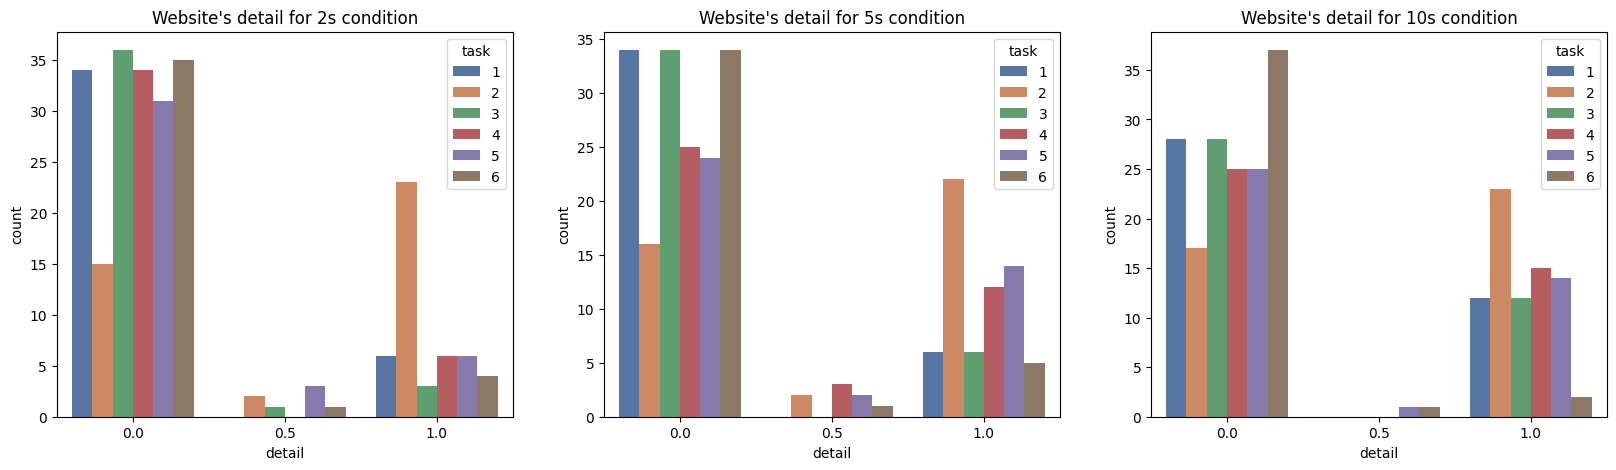

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

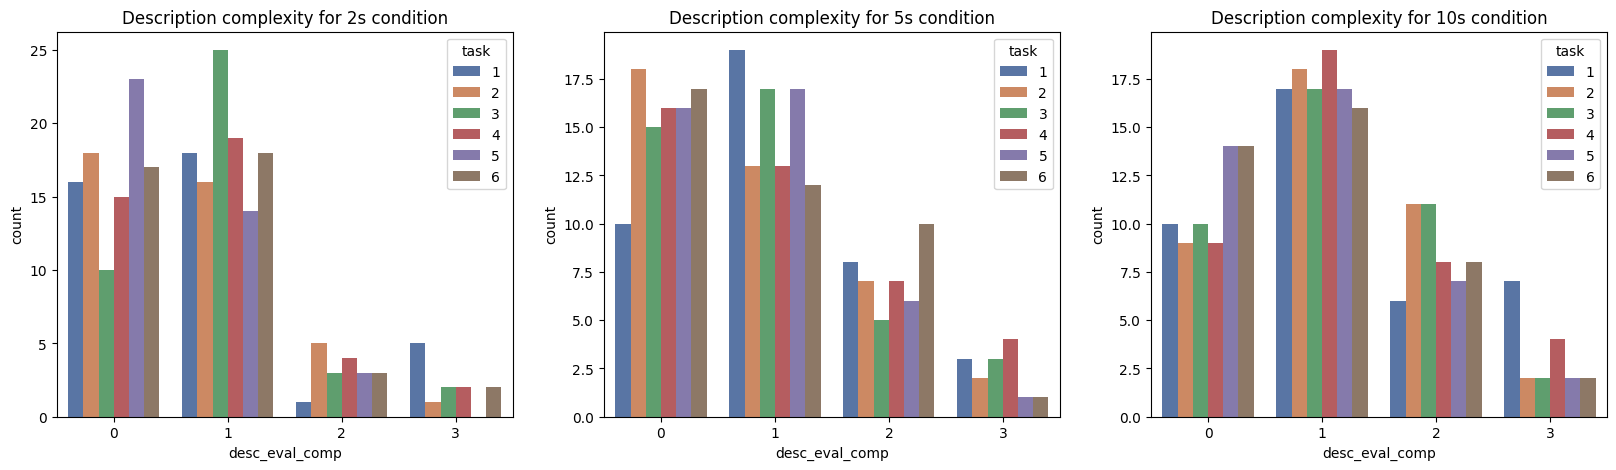

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

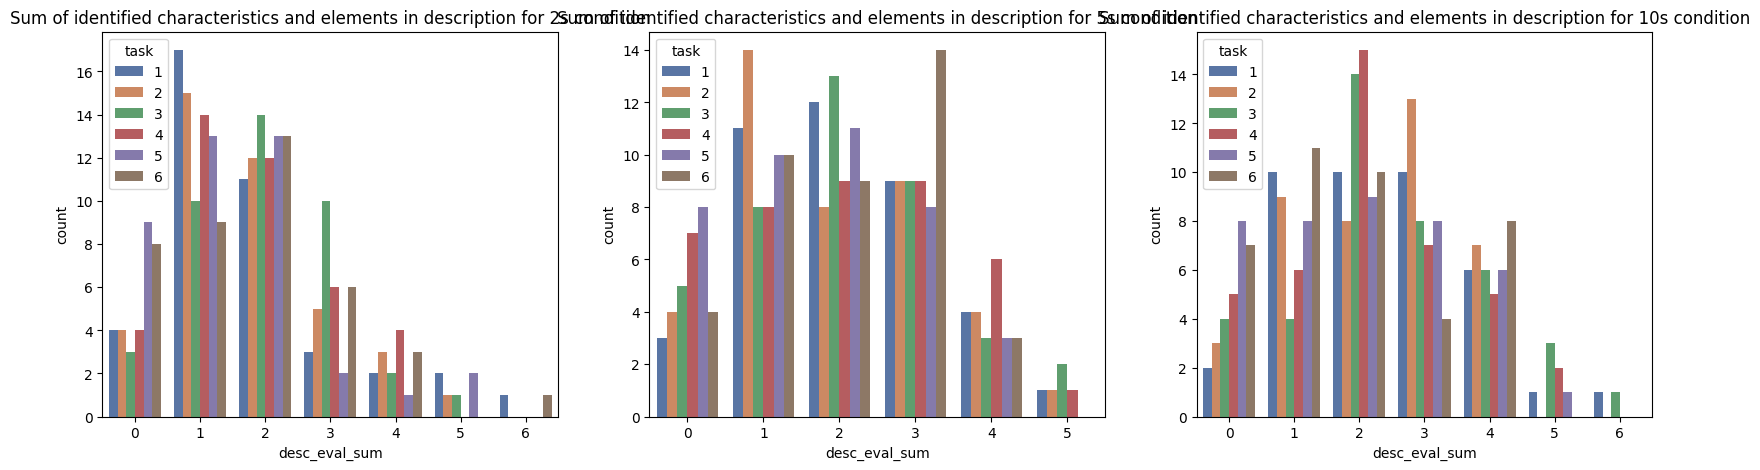

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
for col in ['company', 'purpose', 'detail', 'desc_eval_comp', 'desc_eval_sum']:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))
    my_bar_grouped(data[data.interval == '2s'], col, 'task', open_text[col] + ' for 2s condition', ax=ax1)
    my_bar_grouped(data[data.interval == '5s'], col, 'task', open_text[col] + ' for 5s condition', ax=ax2)
    my_bar_grouped(data[data.interval == '10s'], col, 'task', open_text[col] + ' for 10s condition', ax=ax3)

**Complexity and time interval - 2 sec vs. 5 sec.**

In [18]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '10s'], column, 'task_interval', column)

PQ
----> pvalue: 8.829695352049756e-24

Post-hoc testing:
('0_2s', '1_2s')      0.2233554774886265                   0
('0_2s', '2_2s')    1.3566878961618813e-12                   1
('0_2s', '0_5s')      0.2635286655984696                   0
('0_2s', '1_5s')     0.18617991618377697                   0
('0_2s', '2_5s')    6.333636115153371e-10                   1
('1_2s', '2_2s')    4.3749347892782627e-10                   1
('1_2s', '0_5s')     0.01921219839725095                   1
('1_2s', '1_5s')       0.865319222023579                   0
('1_2s', '2_5s')    8.581936939631335e-08                   1
('2_2s', '0_5s')    8.686468012961982e-14                   1
('2_2s', '1_5s')    3.959009733603501e-09                   1
('2_2s', '2_5s')      0.6297264094686748                   0
('0_5s', '1_5s')    0.017770109784483897                   1
('0_5s', '2_5s')    1.1366280860022259e-10                   1
('1_5s', '2_5s')    2.431201277073546e-07                   1



HQ
----> pval

In [19]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '10s'], column, 'task_interval', column)

desc_token_count
 pvalue: 0.20552684103918095



**Complexity and time interval - 5 sec vs. 10 sec.**

In [20]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '2s'], column, 'task_interval', column)

PQ
----> pvalue: 8.258627813479368e-21

Post-hoc testing:
('0_5s', '1_5s')    0.017770109784483897                   1
('0_5s', '2_5s')    1.704942129003339e-10                   1
('0_5s', '0_10s')     0.5028408018213921                   0
('0_5s', '1_10s')   0.025468390297970458                   1
('0_5s', '2_10s')   5.899445935076588e-11                   1
('1_5s', '2_5s')    2.778515745226909e-07                   1
('1_5s', '0_10s')    0.11532588010940434                   0
('1_5s', '1_10s')     0.7946401856095633                   0
('1_5s', '2_10s')   4.131522065540807e-07                   1
('2_5s', '0_10s')   1.8078238621901665e-09                   1
('2_5s', '1_10s')   1.9150447669601385e-08                   1
('2_5s', '2_10s')     0.5587596728628667                   0
('0_10s', '1_10s')   0.12647421292807318                   0
('0_10s', '2_10s')  7.079213558999917e-10                   1
('1_10s', '2_10s')  4.542364359892389e-08                   1



HQ
----> pvalu

In [21]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '2s'], column, 'task_interval', column)

desc_token_count
 pvalue: 0.09762784399450714



**Complexity and time interval - 2 sec vs. 10 sec.**

In [22]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data[data.interval != '5s'], column, 'task_interval', column)

PQ
----> pvalue: 3.444935702944853e-23

Post-hoc testing:
('0_2s', '1_2s')      0.2427153692987799                   0
('0_2s', '2_2s')    1.6666309803108545e-12                   1
('0_2s', '0_10s')     0.7608273828064366                   0
('0_2s', '1_10s')     0.2427153692987799                   0
('0_2s', '2_10s')   4.1965104373383184e-10                   1
('1_2s', '2_2s')    4.1965104373383184e-10                   1
('1_2s', '0_10s')     0.1538074360914046                   0
('1_2s', '1_10s')      0.903192428850794                   0
('1_2s', '2_10s')   1.2142608313802352e-07                   1
('2_2s', '0_10s')   1.6666309803108545e-12                   1
('2_2s', '1_10s')   3.027614653724379e-10                   1
('2_2s', '2_10s')     0.7165883525252639                   0
('0_10s', '1_10s')    0.1538074360914046                   0
('0_10s', '2_10s')  4.1965104373383184e-10                   1
('1_10s', '2_10s')  3.8934551656220475e-08                   1



HQ
----> 

In [23]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data[data.interval != '5s'], column, 'task_interval', column)

desc_token_count
----> pvalue: 0.00020284578535254485

Post-hoc testing:
('0_2s', '1_2s')      0.8992116478495326                   0
('0_2s', '2_2s')     0.19697422925784258                   0
('0_2s', '0_10s')     0.0133603927961862                   1
('0_2s', '1_10s')    0.19697422925784258                   0
('0_2s', '2_10s')     0.2918215040276809                   0
('1_2s', '2_2s')     0.16111508513349473                   0
('1_2s', '0_10s')     0.0133603927961862                   1
('1_2s', '1_10s')    0.19697422925784258                   0
('1_2s', '2_10s')     0.2918215040276809                   0
('2_2s', '0_10s')   0.00010790837318256708                   1
('2_2s', '1_10s')   0.012928813873181988                   1
('2_2s', '2_10s')    0.01797686118605911                   1
('0_10s', '1_10s')    0.2918215040276809                   0
('0_10s', '2_10s')   0.19697422925784258                   0
('1_10s', '2_10s')    0.7036569740943523                   0





**Complexity and time - all groups**

In [24]:
for column in ['PQ', 'HQ', 'ATT']:
    my_test(stats.kruskal, data, column, 'task_interval', column)

PQ
----> pvalue: 2.638026073622221e-32

Post-hoc testing:
('0_2s', '1_2s')     0.24740914429509397                   0
('0_2s', '2_2s')    2.666609568497367e-12                   1
('0_2s', '0_5s')      0.2936462273811518                   0
('0_2s', '1_5s')      0.1966059914900685                   0
('0_2s', '2_5s')    7.600363338184044e-10                   1
('0_2s', '0_10s')     0.7746606079483718                   0
('0_2s', '1_10s')    0.25889639391869856                   0
('0_2s', '2_10s')   6.71441669974131e-10                   1
('1_2s', '2_2s')    5.999910568153046e-10                   1
('1_2s', '0_5s')    0.023054638076701137                   1
('1_2s', '1_5s')      0.8900426283671099                   0
('1_2s', '2_5s')    9.611769372387094e-08                   1
('1_2s', '0_10s')     0.1538074360914046                   0
('1_2s', '1_10s')      0.903192428850794                   0
('1_2s', '2_10s')   1.4571129976562824e-07                   1
('2_2s', '0_5s')    2

In [25]:
for column in ['desc_token_count']:
    my_test(stats.kruskal, data, column, 'task_interval', column)

desc_token_count
----> pvalue: 0.002021320221303847

Post-hoc testing:
('0_2s', '1_2s')       0.924903409216662                   0
('0_2s', '2_2s')     0.29546134388676387                   0
('0_2s', '0_5s')     0.44639454065032114                   0
('0_2s', '1_5s')      0.9092715364608797                   0
('0_2s', '2_5s')      0.9092715364608797                   0
('0_2s', '0_10s')    0.03206494271084688                   1
('0_2s', '1_10s')    0.29546134388676387                   0
('0_2s', '2_10s')    0.41367593002681763                   0
('1_2s', '2_2s')      0.2577841362135916                   0
('1_2s', '0_5s')      0.4969343305020296                   0
('1_2s', '1_5s')      0.9291166550849427                   0
('1_2s', '2_5s')      0.9092715364608797                   0
('1_2s', '0_10s')    0.03206494271084688                   1
('1_2s', '1_10s')    0.29546134388676387                   0
('1_2s', '2_10s')    0.41367593002681763                   0
('2_2s', '0_5s

**Complexity and time interval - categorical variables.**

In [26]:
my_chi(fixed_data, 'company', 'task_interval', {0: [0.5]})

task_interval  0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
company                                                               
0.0                3    14     3      6     7     8     10     7     5
1.0               77    64    77     74    71    72     70    71    75

----> pvalue: 0.04992822567992002

expected frequencies:
[[ 7.05882353  6.88235294  7.05882353  7.05882353  6.88235294  7.05882353
   7.05882353  6.88235294  7.05882353]
 [72.94117647 71.11764706 72.94117647 72.94117647 71.11764706 72.94117647
  72.94117647 71.11764706 72.94117647]]

Post-hoc testing:
('0_10s', '0_2s')     0.3166597730356797                   0
('0_10s', '0_5s')                    1.0                   0
('0_10s', '1_10s')    0.9195791448776838                   0
('0_10s', '1_2s')     0.8339112366791017                   0
('0_10s', '1_5s')     0.8339112366791017                   0
('0_10s', '2_10s')    0.7422352900696663                   0
('0_10s', '2_2s')     0.8339112366791017      

**Purpose**

In [27]:
my_chi(fixed_data, 'purpose', 'task_interval', {0: [0.5]})

task_interval  0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
purpose                                                               
0.0              1.0  14.0  11.0    2.0   9.0   5.0   22.0  40.0  33.0
1.0             79.0  64.0  69.0   78.0  69.0  75.0   58.0  38.0  47.0

----> pvalue: 3.6405371349906845e-23

expected frequencies:
[[15.35014006 14.96638655 15.35014006 15.35014006 14.96638655 15.35014006
  15.35014006 14.96638655 15.35014006]
 [64.64985994 63.03361345 64.64985994 64.64985994 63.03361345 64.64985994
  64.64985994 63.03361345 64.64985994]]

Post-hoc testing:
('0_10s', '0_2s')   0.0013763182264388437                   1
('0_10s', '0_5s')   0.006587870723869362                   1
('0_10s', '1_10s')                   1.0                   0
('0_10s', '1_2s')    0.01723622913420356                   1
('0_10s', '1_5s')    0.08642061221537045                   0
('0_10s', '2_10s')  2.0477672480992754e-05                   1
('0_10s', '2_2s')   9.809797643215008e-1

**Detail**

In [28]:
my_chi(fixed_data, 'detail', 'task_interval', {0: [0.5]})

task_interval  0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
detail                                                                
0.0             45.0  50.0  52.0   53.0  69.0  62.0   64.0  68.0  61.0
1.0             35.0  28.0  28.0   27.0   9.0  18.0   16.0  10.0  19.0

----> pvalue: 3.2941893835046875e-06

expected frequencies:
[[58.71148459 57.24369748 58.71148459 58.71148459 57.24369748 58.71148459
  58.71148459 57.24369748 58.71148459]
 [21.28851541 20.75630252 21.28851541 21.28851541 20.75630252 21.28851541
  21.28851541 20.75630252 21.28851541]]

Post-hoc testing:
('0_10s', '0_2s')    0.18230842017887017                   0
('0_10s', '0_5s')    0.17127186813521747                   0
('0_10s', '1_10s')   0.14864402565083093                   0
('0_10s', '1_2s')   0.0005164542765156185                   1
('0_10s', '1_5s')   0.019577384953115215                   1
('0_10s', '2_10s')  0.009741731442584983                   1
('0_10s', '2_2s')   0.0006336218860434589 

In [29]:
my_chi(fixed_data, 'desc_eval_comp', 'task_interval', {0: [1], 2: [3]})

task_interval   0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
desc_eval_comp                                                         
0                  54    67    60     55    69    61     61    71    62
2                  26    11    20     25     9    19     19     7    18

----> pvalue: 0.0012034753806598867

expected frequencies:
[[62.74509804 61.17647059 62.74509804 62.74509804 61.17647059 62.74509804
  62.74509804 61.17647059 62.74509804]
 [17.25490196 16.82352941 17.25490196 17.25490196 16.82352941 17.25490196
  17.25490196 16.82352941 17.25490196]]

Post-hoc testing:
('0_10s', '0_2s')    0.07127291405682247                   0
('0_10s', '0_5s')    0.36679724965614224                   0
('0_10s', '1_10s')                   1.0                   0
('0_10s', '1_2s')   0.032699862853278805                   1
('0_10s', '1_5s')      0.338177998065381                   0
('0_10s', '2_10s')     0.338177998065381                   0
('0_10s', '2_2s')    0.02085098435739983

In [30]:
my_chi(fixed_data, 'desc_eval_elem', 'task_interval', {1: [2], 3: [4, 5]})

task_interval   0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
desc_eval_elem                                                         
0                11.0  13.0  13.0   11.0   9.0  16.0   21.0  31.0  25.0
1                42.0  58.0  54.0   37.0  54.0  45.0   41.0  39.0  45.0
3                27.0   7.0  13.0   32.0  15.0  19.0   18.0   8.0  10.0

----> pvalue: 5.807555647133067e-09

expected frequencies:
[[16.80672269 16.38655462 16.80672269 16.80672269 16.38655462 16.80672269
  16.80672269 16.38655462 16.80672269]
 [46.49859944 45.33613445 46.49859944 46.49859944 45.33613445 46.49859944
  46.49859944 45.33613445 46.49859944]
 [16.69467787 16.27731092 16.69467787 16.69467787 16.27731092 16.69467787
  16.69467787 16.27731092 16.69467787]]

Post-hoc testing:
('0_10s', '0_2s')   0.0037304078930102203                   1
('0_10s', '0_5s')    0.04112900277277964                   1
('0_10s', '1_10s')    0.1576997222725703                   0
('0_10s', '1_2s')    0.06438698486959

In [31]:
my_chi(fixed_data, 'desc_eval_char', 'task_interval', {1: [2, 3]})

task_interval   0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
desc_eval_char                                                         
0                50.0  51.0  43.0   67.0  63.0  53.0   55.0  42.0  33.0
1                30.0  27.0  37.0   13.0  15.0  27.0   25.0  36.0  47.0

----> pvalue: 5.62153020896163e-08

expected frequencies:
[[51.20448179 49.92436975 51.20448179 51.20448179 49.92436975 51.20448179
  51.20448179 49.92436975 51.20448179]
 [28.79551821 28.07563025 28.79551821 28.79551821 28.07563025 28.79551821
  28.79551821 28.07563025 28.79551821]]

Post-hoc testing:
('0_10s', '0_2s')     0.6774438118312399                   0
('0_10s', '0_5s')    0.18768498367902303                   0
('0_10s', '1_10s')  0.012418305671920435                   1
('0_10s', '1_2s')    0.03311667608572056                   1
('0_10s', '1_5s')     0.6685203202582066                   0
('0_10s', '2_10s')   0.28204225555266477                   0
('0_10s', '2_2s')    0.18768498367902303 

In [32]:
my_chi(fixed_data, 'desc_eval_sum', 'task_interval', {1: [2, 3], 4: [5, 6]})

task_interval  0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
desc_eval_sum                                                         
0                5.0   8.0   7.0    9.0   7.0  12.0   15.0  17.0  12.0
1               60.0  62.0  63.0   54.0  64.0  56.0   50.0  54.0  62.0
4               15.0   8.0  10.0   17.0   7.0  12.0   15.0   7.0   6.0

----> pvalue: 0.027251173443109344

expected frequencies:
[[10.30812325 10.05042017 10.30812325 10.30812325 10.05042017 10.30812325
  10.30812325 10.05042017 10.30812325]
 [58.82352941 57.35294118 58.82352941 58.82352941 57.35294118 58.82352941
  58.82352941 57.35294118 58.82352941]
 [10.86834734 10.59663866 10.86834734 10.86834734 10.59663866 10.86834734
  10.86834734 10.59663866 10.86834734]]

Post-hoc testing:
('0_10s', '0_2s')     0.4185978604679771                   0
('0_10s', '0_5s')     0.4185978604679771                   0
('0_10s', '1_10s')    0.4185978604679771                   0
('0_10s', '1_2s')     0.4185978604679771    

In [33]:
my_chi(fixed_data, 'desc_word_count_group', 'task_interval')

task_interval          0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  2_5s
desc_word_count_group                                                         
high                      35    20    26     30    20    29     30    15    29
low                       15    32    30     22    27    32     18    33    29
med                       30    26    24     28    31    19     32    30    22

----> pvalue: 0.012010610117946314

expected frequencies:
[[26.21848739 25.56302521 26.21848739 26.21848739 25.56302521 26.21848739
  26.21848739 25.56302521 26.21848739]
 [26.66666667 26.         26.66666667 26.66666667 26.         26.66666667
  26.66666667 26.         26.66666667]
 [27.11484594 26.43697479 27.11484594 27.11484594 26.43697479 27.11484594
  27.11484594 26.43697479 27.11484594]]

Post-hoc testing:
('0_10s', '0_2s')    0.09222668433118196                   0
('0_10s', '0_5s')    0.15321316816199346                   0
('0_10s', '1_10s')   0.36365304608450055                   0
('0_

In [34]:
my_chi(fixed_data, 'desc_token_count_group', 'task_interval')

task_interval           0_10s  0_2s  0_5s  1_10s  1_2s  1_5s  2_10s  2_2s  \
desc_token_count_group                                                      
high                       36    18    23     27    13    22     25    11   
low                        12    26    23     19    17    31     21    31   
med                        32    34    34     34    48    27     34    36   

task_interval           2_5s  
desc_token_count_group        
high                      27  
low                       30  
med                       23  

----> pvalue: 5.297577348567228e-05

expected frequencies:
[[22.63305322 22.06722689 22.63305322 22.63305322 22.06722689 22.63305322
  22.63305322 22.06722689 22.63305322]
 [23.52941176 22.94117647 23.52941176 23.52941176 22.94117647 23.52941176
  23.52941176 22.94117647 23.52941176]
 [33.83753501 32.99159664 33.83753501 33.83753501 32.99159664 33.83753501
  33.83753501 32.99159664 33.83753501]]

Post-hoc testing:
('0_10s', '0_2s')   0.019224932467401645